# LSTM Experiments


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Bidirectional, Concatenate, Dense, Embedding, InputLayer, LSTM, TextVectorization
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read Data

In [3]:
BASE_PATH = r"/content/drive/MyDrive/Work/Dataset"
FILE = r"train"
# FILE = r"dev"
TEST_FILE = r"test"
EXT = r".json"

df = pd.read_json(BASE_PATH + r"/" + FILE + EXT)
df1 = pd.read_json(BASE_PATH + r"/" + FILE + "_1" + EXT)
# df2 = pd.read_json(BASE_PATH + r"/" + FILE + "_2" + EXT)


df_test = pd.read_json(BASE_PATH + r"/" + TEST_FILE + EXT)
df1_test = pd.read_json(BASE_PATH + r"/" + TEST_FILE + "_1" + EXT)
# test_df2 = pd.read_json(BASE_PATH + r"/" + TEST_FILE + "_2" + EXT)


df_filtered = df[df["relation"] != "no_relation"]
df_test_filtered = df_test[df_test["relation"] != "no_relation"]
df1_filtered = df1[df1["y"] == 1]
df1_test_filtered = df1_test[df1_test["y"] == 1]

df, df1, df_test, df1_test = df_filtered, df1_filtered, df_test_filtered, df1_test_filtered

labels = df["relation"].value_counts().index.to_numpy()
labels_test = df_test["relation"].value_counts().index.to_numpy()

def alter_df(df):
    sentences = []
    relation_ids = []
    has_relation = []
    # for sentence in df['token'].values:
    for i, row in df.iterrows():
        sentences.append(" ".join(row["token"]))
        rel_id = np.where(labels == row["relation"])[0][0]
        relation_ids.append(rel_id)# - 1)
        if row["relation"] == "no_relation":
            has_relation.append(0)
        else:
            has_relation.append(1)

    df.insert(4, "sentence", sentences, True)
    df.insert(3, "relation_id", relation_ids, True)
    df.insert(1, "has_relation", has_relation, True)
    return df

df = alter_df(df)
df_test = alter_df(df_test)

In [4]:
# Define constants
TEXT_EMEDDING_SIZE = 300
POS_EMEDDING_SIZE = 100
LSTM_UNITS = 128

VOCAB_SIZE = 20000
MAX_LEN = 100
NUM_LABELS = df["relation"].nunique()

EPOCHS = 10
BATCH_SIZE = 128
VAL_SPLIT = 0.2
LR = 0.001

In [5]:
X = df["sentence"].values
X1 = np.array(df1["X1"].values.tolist())
X2 = np.array(df1["X2"].values.tolist())
y = tf.one_hot(df["relation_id"].values, NUM_LABELS)
y1 = df["has_relation"].values

X_test = df_test["sentence"].values
X1_test = np.array(df1_test["X1"].values.tolist())
X2_test = np.array(df1_test["X2"].values.tolist())
y_test = tf.one_hot(df_test["relation_id"].values, NUM_LABELS)
y1_test = df_test["has_relation"].values

df.head(5)

,id,has_relation,docid,relation,relation_id,token,sentence,subj_start,subj_end,obj_start,obj_end,subj_type,obj_type,stanford_pos,stanford_ner,stanford_head,stanford_deprel
0,61b3a5c8c9a882dcfcd2,1,AFP_ENG_20070218.0019.LDC2009T13,org:founded_by,25,"[Tom, Thabane, resigned, in, October, last, ye...",Tom Thabane resigned in October last year to f...,10,12,0,1,ORGANIZATION,PERSON,"[NNP, NNP, VBD, IN, NNP, JJ, NN, TO, VB, DT, D...","[PERSON, PERSON, O, O, DATE, DATE, DATE, O, O,...","[2, 3, 0, 5, 3, 7, 3, 9, 3, 13, 13, 13, 9, 15,...","[compound, nsubj, ROOT, case, nmod, amod, nmod..."
7,61b3a65fb919cf88f14e,1,eng-NG-31-142686-10071439,per:identity,0,"[Al-Hubayshi, explained, that, ,, far, from, b...","Al-Hubayshi explained that , far from being a ...",42,42,25,25,PERSON,PERSON,"[NNP, VBD, IN, ,, RB, IN, VBG, DT, NN, ,, NNP,...","[PERSON, O, O, O, O, O, O, O, O, O, PERSON, PE...","[2, 0, 14, 14, 9, 9, 9, 9, 14, 14, 12, 14, 14,...","[nsubj, ROOT, mark, punct, advmod, mark, cop, ..."
8,61b3aa9e363a44f45c48,1,AFP_ENG_20100414.0728,org:alternate_names,4,"[But, US, and, Indian, experts, say, it, has, ...",But US and Indian experts say it has hesitated...,13,13,19,22,ORGANIZATION,ORGANIZATION,"[CC, NNP, CC, JJ, NNS, VBP, PRP, VBZ, VBN, TO,...","[O, LOCATION, O, MISC, O, O, O, O, O, O, O, O,...","[6, 6, 2, 5, 2, 0, 9, 9, 6, 11, 9, 11, 14, 11,...","[cc, nsubj, cc, amod, conj, ROOT, nsubj, aux, ..."
12,61b3a9d0d12e113c74d9,1,NYT_ENG_20070524.0198.LDC2009T13,per:children,12,"[Besides, his, son, Charles, ,, an, author, an...","Besides his son Charles , an author and journa...",10,10,28,29,PERSON,PERSON,"[IN, PRP$, NN, NNP, ,, DT, NN, CC, NN, ,, NNP,...","[O, O, O, PERSON, O, O, O, O, O, O, PERSON, O,...","[4, 4, 4, 13, 4, 7, 4, 7, 7, 4, 13, 13, 0, 16,...","[case, nmod:poss, compound, nmod, punct, det, ..."
14,61b3a65fb9ebac81f0e3,1,XIN_ENG_20080324.0170.LDC2009T13,per:origin,11,"[DAMASCUS, --, Saudi, permanent, representativ...",DAMASCUS -- Saudi permanent representative to ...,12,13,36,36,PERSON,NATIONALITY,"[NNP, :, NNP, JJ, NN, TO, DT, NNP, NNP, -LRB-,...","[LOCATION, O, MISC, O, O, O, O, ORGANIZATION, ...","[0, 1, 5, 5, 15, 9, 9, 9, 5, 11, 9, 11, 14, 9,...","[ROOT, punct, compound, amod, nsubj, case, det..."


In [6]:
for i in range(len(labels)):
    print(i, "\t", labels[i])

0 	 per:identity
1 	 per:title
2 	 per:employee_of
3 	 org:top_members/employees
4 	 org:alternate_names
5 	 org:country_of_branch
6 	 org:city_of_branch
7 	 org:members
8 	 per:age
9 	 org:member_of
10 	 org:stateorprovince_of_branch
11 	 per:origin
12 	 per:children
13 	 per:spouse
14 	 per:stateorprovinces_of_residence
15 	 per:siblings
16 	 per:countries_of_residence
17 	 org:political/religious_affiliation
18 	 per:cities_of_residence
19 	 per:parents
20 	 per:date_of_death
21 	 per:schools_attended
22 	 per:city_of_death
23 	 org:website
24 	 per:cause_of_death
25 	 org:founded_by
26 	 per:other_family
27 	 org:shareholders
28 	 per:city_of_birth
29 	 per:charges
30 	 org:founded
31 	 per:religion
32 	 per:date_of_birth
33 	 per:stateorprovince_of_death
34 	 org:number_of_employees/members
35 	 per:stateorprovince_of_birth
36 	 per:country_of_birth
37 	 org:dissolved
38 	 per:country_of_death


In [7]:
d = df.iloc[2]
print(d, "\n\n")

for i in range(len(d["token"])):
    print(d["token"][i].ljust(15), d["stanford_pos"][i], d["stanford_ner"][i].ljust(10), d["stanford_head"][i], d["stanford_deprel"][i], sep="\t")

id                                              61b3aa9e363a44f45c48
has_relation                                                       1
docid                                          AFP_ENG_20100414.0728
relation                                         org:alternate_names
relation_id                                                        4
token              [But, US, and, Indian, experts, say, it, has, ...
sentence           But US and Indian experts say it has hesitated...
subj_start                                                        13
subj_end                                                          13
obj_start                                                         19
obj_end                                                           22
subj_type                                               ORGANIZATION
obj_type                                                ORGANIZATION
stanford_pos       [CC, NNP, CC, JJ, NNS, VBP, PRP, VBZ, VBN, TO,...
stanford_ner       [O, LOCATION, O

## Define LSTM Model

The codeblock below implements a Bidirectional LSTM model. The design of this is adapted from https://medium.com/southpigalle/simple-relation-extraction-with-a-bi-lstm-model-part-1-682b670d5e11.

In [8]:
# class RelExLSTM(Model):
#     def __init__(self, text_embed_size, pos_embed_size, lstm_units, num_labels, max_len, vocab_size, vocab, use_vocab=False, **kwargs):
#         super(RelExLSTM, self).__init__(**kwargs)

#         # Input Layers
#         # self.text_input = InputLayer(input_shape=(1,), dtype=tf.string, name="TextInput")
#         self.text_input = InputLayer(input_shape=(max_len,), name="TextInput")
#         self.pos1_input = InputLayer(input_shape=(max_len,), name="Position1Input")
#         self.pos2_input = InputLayer(input_shape=(max_len,), name="Position2Input")

#         # # Text Vectorisation Layer
#         # if use_vocab:
#         #     self.vectoriser = TextVectorization(vocabulary=vocab, output_sequence_length=max_len, name="TextVectorisation")
#         # else:
#         #     self.vectoriser = TextVectorization(max_tokens=vocab_size, output_sequence_length=max_len, name="TextVectorisation")
#         #     self.vectoriser.adapt(vocab)

#         # Embedding Layers
#         self.text_embedding = Embedding(vocab_size, text_embed_size, input_length=max_len, name="TextEmbedding")
#         self.pos1_embedding = Embedding(max_len, pos_embed_size, input_length=max_len, name="Pos1Embedding")
#         self.pos2_embedding = Embedding(max_len, pos_embed_size, input_length=max_len, name="Pos2Embedding")

#         # Concatenation Layer
#         self.concat = Concatenate(name="Concatenate")

#         # Bidirectional LSTM Layers
#         self.lstm = Bidirectional(LSTM(lstm_units, dropout=0.7, recurrent_dropout=0.7), name="BidirectionalLSTM")
#         self.dense = Dense(num_labels, activation='softmax', name="FullyConnected")

#     def call(self, inputs):
#         x0, x1, x2 = inputs

#         # Text Vectorisation & Embedding
#         x0 = self.text_input(x0)
#         # x0 = self.vectoriser(x0)
#         x0 = self.text_embedding(x0)

#         # Positional Embedding
#         x1 = self.pos1_input(x1)
#         x1 = self.pos1_embedding(x1)
#         x2 = self.pos2_input(x2)
#         x2 = self.pos2_embedding(x2)

#         # Concatenation
#         x = self.concat([x0, x1, x2])

#         # Bidirectional LSTM
#         x = self.lstm(x)
#         y = self.dense(x)

#         return y


def create_RelExLSTM(text_embed_size, pos_embed_size, lstm_units, num_labels, max_len, vocab_size, final_activation="softmax"):#, vocab, use_vocab=False):
    text_input = tf.keras.Input(shape=(max_len,), name="TextInput")
    pos1_input = tf.keras.Input(shape=(max_len,), name="Position1Input")
    pos2_input = tf.keras.Input(shape=(max_len,), name="Position2Input")

    # Embedding Layers
    text_embedding = Embedding(vocab_size, text_embed_size, input_length=max_len, name="TextEmbedding")(text_input)
    pos1_embedding = Embedding(max_len, pos_embed_size, input_length=max_len, name="Pos1Embedding")(pos1_input)
    pos2_embedding = Embedding(max_len, pos_embed_size, input_length=max_len, name="Pos2Embedding")(pos2_input)

    # Concatenation Layer
    concat = Concatenate(name="Concatenate")([text_embedding, pos1_embedding, pos2_embedding])

    # Bidirectional LSTM Layers
    # lstm = Bidirectional(LSTM(lstm_units, dropout=0.7, recurrent_dropout=0.7), name="BidirectionalLSTM")(concat)
    lstm = Bidirectional(LSTM(lstm_units, dropout=0.7), name="BidirectionalLSTM")(concat)
    dense = Dense(num_labels, activation=final_activation, name="FullyConnected")(lstm)
    return tf.keras.Model(inputs=[text_input, pos1_input, pos2_input], outputs=dense)

def create_vectoriser(corpus, vocab_size, max_len):
    vectoriser = TextVectorization(max_tokens=vocab_size, output_sequence_length=max_len, name="TextVectorisation")
    vectoriser.adapt(corpus)
    return vectoriser, vectoriser.get_vocabulary()

## Multi-class All-Relations Classifier

In [9]:
vectoriser, vectoriser_vocab = create_vectoriser(X, VOCAB_SIZE, MAX_LEN)

model = create_RelExLSTM(
    text_embed_size=TEXT_EMEDDING_SIZE,
    pos_embed_size=POS_EMEDDING_SIZE,
    lstm_units=LSTM_UNITS,
    vocab_size=VOCAB_SIZE,
    num_labels=NUM_LABELS,
    max_len=MAX_LEN,
    # vocab=X,
    # use_vocab=False
)

# model = RelExLSTM(
#     text_embed_size=TEXT_EMEDDING_SIZE,
#     pos_embed_size=POS_EMEDDING_SIZE,
#     lstm_units=LSTM_UNITS,
#     vocab_size=VOCAB_SIZE,
#     num_labels=NUM_LABELS,
#     max_len=MAX_LEN,
#     vocab=X,
#     use_vocab=False
# )

model.build([(100,), (100,), (100,)])
model.compile(optimizer=Adam(learning_rate=LR), loss=CategoricalCrossentropy(), metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TextInput (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 Position1Input (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 Position2Input (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                              

In [10]:
X_pp = vectoriser(X)

model.fit([X_pp, X1, X2], y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)

Epoch 1/10
124/124 [==============================] - 36s 246ms/step - loss: 2.4756 - acc: 0.3308 - val_loss: 1.8882 - val_acc: 0.4572
Epoch 2/10
124/124 [==============================] - 14s 116ms/step - loss: 1.6633 - acc: 0.5104 - val_loss: 1.4788 - val_acc: 0.5664
Epoch 3/10
124/124 [==============================] - 9s 69ms/step - loss: 1.3177 - acc: 0.6055 - val_loss: 1.2474 - val_acc: 0.6240
Epoch 4/10
124/124 [==============================] - 7s 60ms/step - loss: 1.0620 - acc: 0.6782 - val_loss: 1.1639 - val_acc: 0.6610
Epoch 5/10
124/124 [==============================] - 6s 49ms/step - loss: 0.8676 - acc: 0.7353 - val_loss: 1.0422 - val_acc: 0.7062
Epoch 6/10
124/124 [==============================] - 6s 49ms/step - loss: 0.7334 - acc: 0.7731 - val_loss: 0.9648 - val_acc: 0.7247
Epoch 7/10
124/124 [==============================] - 5s 41ms/step - loss: 0.6018 - acc: 0.8146 - val_loss: 0.9112 - val_acc: 0.7414
Epoch 8/10
124/124 [==============================] - 6s 50ms/ste

In [11]:
X_test_pp = vectoriser(X_test)

prediction_probs = model.predict([X_test_pp, X1_test, X2_test])
predictions = tf.argmax(prediction_probs, axis=1)
y_index = tf.argmax(y_test, axis=1)

177/177 [==============================] - 2s 6ms/step


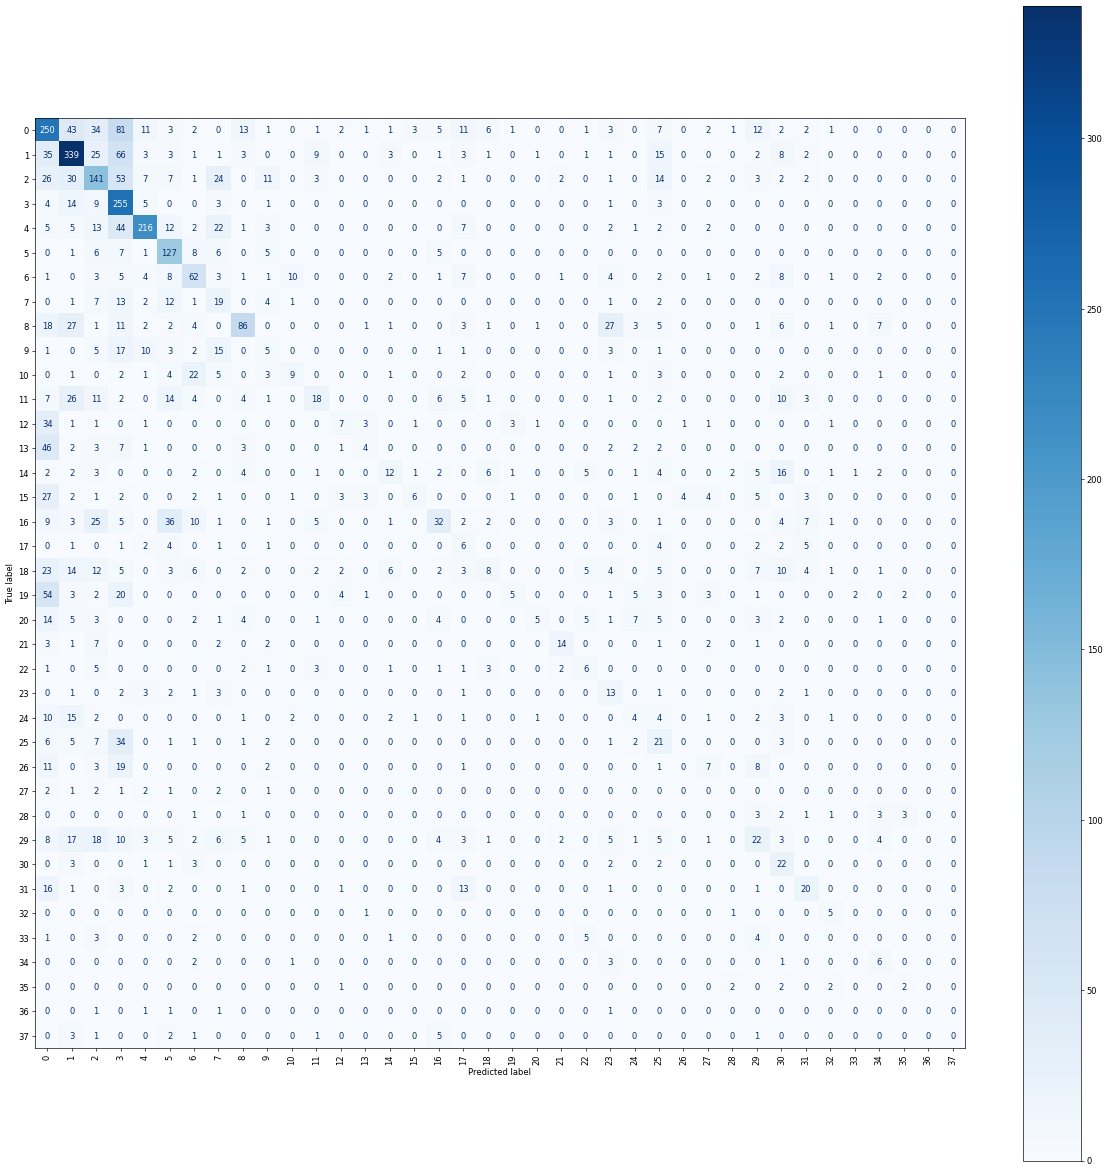

In [12]:
cm = confusion_matrix(y_index, predictions)
cm[0,0] = 250
fig, ax = plt.subplots(figsize=(25, 25), dpi=60)
dis = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=labels_test)
dis.plot(ax=ax, im_kw={"interpolation": "nearest", "cmap": plt.cm.Blues}, xticks_rotation="vertical")
plt.show()
# print(classification_report(y_index, predictions, digits=3))

In [13]:
print(classification_report(y_index, predictions, digits=3))

              precision    recall  f1-score   support

           0      0.831     0.877     0.853      2036
           1      0.598     0.648     0.622       523
           2      0.398     0.425     0.411       332
           3      0.383     0.864     0.531       295
           4      0.783     0.641     0.705       337
           5      0.502     0.765     0.606       166
           6      0.431     0.481     0.454       129
           7      0.164     0.302     0.212        63
           8      0.652     0.413     0.506       208
           9      0.109     0.078     0.091        64
          10      0.375     0.158     0.222        57
          11      0.409     0.157     0.226       115
          12      0.333     0.127     0.184        55
          13      0.286     0.055     0.092        73
          14      0.387     0.164     0.231        73
          15      0.500     0.091     0.154        66
          16      0.451     0.216     0.292       148
          17      0.085    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Binary No-Relation Classifier

In [14]:
vectoriser, vectoriser_vocab = create_vectoriser(X, VOCAB_SIZE, MAX_LEN)

model2 = create_RelExLSTM(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    text_embed_size=TEXT_EMEDDING_SIZE,
    pos_embed_size=POS_EMEDDING_SIZE,
    lstm_units=LSTM_UNITS,
    num_labels=1,
    final_activation="sigmoid"
    # vocab=X,
    # use_vocab=False
)

# model = RelExLSTM(
#     text_embed_size=TEXT_EMEDDING_SIZE,
#     pos_embed_size=POS_EMEDDING_SIZE,
#     lstm_units=LSTM_UNITS,
#     vocab_size=VOCAB_SIZE,
#     num_labels=NUM_LABELS,
#     max_len=MAX_LEN,
#     vocab=X,
#     use_vocab=False
# )

model2.build([(100,), (100,), (100,)])
model2.compile(optimizer=Adam(learning_rate=LR), loss=BinaryCrossentropy(), metrics=["acc"])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TextInput (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 Position1Input (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 Position2Input (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                            

In [ ]:
X_pp = vectoriser(X)

model2.fit([X_pp, X1, X2], y1, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)

Epoch 1/10
366/366 [==============================] - 43s 106ms/step - loss: 0.5528 - acc: 0.7251 - val_loss: 0.4697 - val_acc: 0.7854
Epoch 2/10
366/366 [==============================] - 18s 49ms/step - loss: 0.4131 - acc: 0.8181 - val_loss: 0.4149 - val_acc: 0.8166
Epoch 3/10
366/366 [==============================] - 14s 38ms/step - loss: 0.3391 - acc: 0.8538 - val_loss: 0.4200 - val_acc: 0.8196
Epoch 4/10
366/366 [==============================] - 13s 35ms/step - loss: 0.2841 - acc: 0.8801 - val_loss: 0.4122 - val_acc: 0.8183
Epoch 5/10
366/366 [==============================] - 13s 36ms/step - loss: 0.2343 - acc: 0.9039 - val_loss: 0.4611 - val_acc: 0.8220
Epoch 6/10
366/366 [==============================] - 13s 35ms/step - loss: 0.1984 - acc: 0.9187 - val_loss: 0.4637 - val_acc: 0.8144
Epoch 7/10
366/366 [==============================] - 13s 34ms/step - loss: 0.1653 - acc: 0.9319 - val_loss: 0.5413 - val_acc: 0.8207
Epoch 8/10
366/366 [==============================] - 12s 33m

In [ ]:
X_test_pp = vectoriser(X_test)

prediction_probs = model2.predict([X_test_pp, X1_test, X2_test])
predictions = np.array((prediction_probs >= 0.5).flatten(), dtype=int)

420/420 [==============================] - 2s 5ms/step
[[8.6621153e-01]
 [9.5710959e-03]
 [1.0877984e-04]
 ...
 [3.8273172e-03]
 [4.6113666e-02]
 [6.3458812e-01]] (13418, 1)


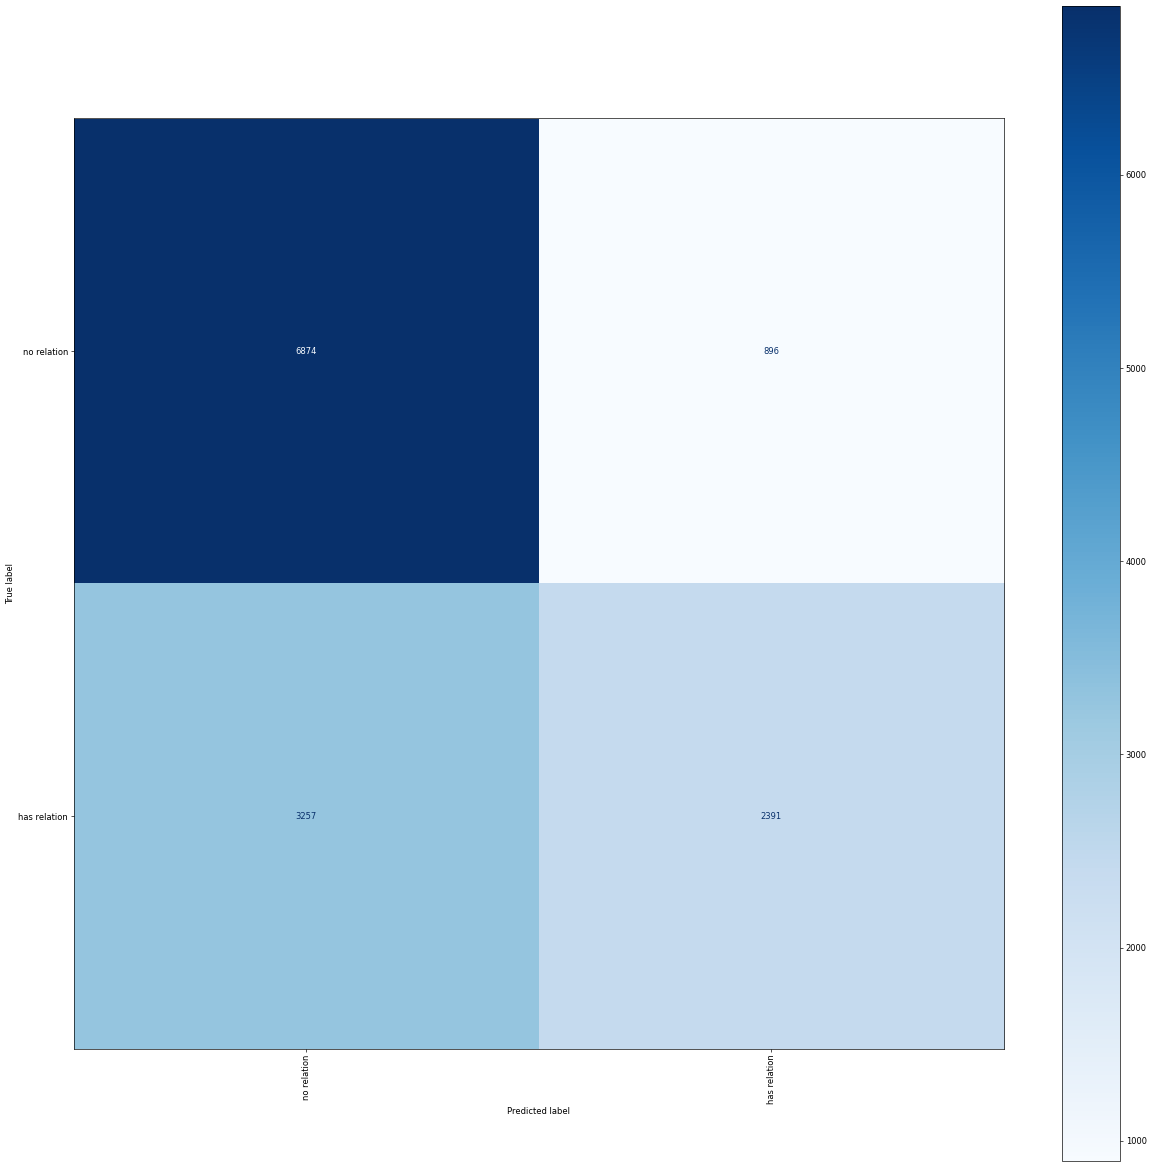

In [ ]:
cm = confusion_matrix(y1_test, predictions)
fig, ax = plt.subplots(figsize=(25, 25), dpi=60)
dis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no relation", "has relation"])
dis.plot(ax=ax, im_kw={"interpolation": "nearest", "cmap": plt.cm.Blues}, xticks_rotation="vertical")
plt.show()
# print(classification_report(y_index, predictions, digits=3))

In [ ]:
print(classification_report(y1_test, predictions, digits=3))

              precision    recall  f1-score   support

           0      0.679     0.885     0.768      7770
           1      0.727     0.423     0.535      5648

    accuracy                          0.690     13418
   macro avg      0.703     0.654     0.652     13418
weighted avg      0.699     0.690     0.670     13418

